# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

Einlesen der Trainings- und Testdaten.

In [3]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [4]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [5]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [6]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [7]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [8]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    # ("ord_enc", OrdinalEncoder()),
    ("scale", MinMaxScaler())
])

In [9]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [10]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add new feature manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(handle_unknown='ignore'), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

### Undersampling

In [11]:
# sort data according to repair status
df_train_1 = df_train[df_train["t_needs_rep"] == 1] 
df_train_0 = df_train[df_train["t_needs_rep"] == 0]

num_r = len(df_train_1) # number of needs-repair pumps
print(f"{num_r} pumps need repairs, therefore we need the same amount of pumps that don't need repairs")

df_sample=df_train_0.sample(num_r) # get same amount of other pumps
df_train_r = pd.concat([df_train_1, df_sample]) # combine data samples
df_train_r = df_train_r.sample(frac=1) # shuffle dataset
print(df_train_r["t_needs_rep"].value_counts())


3356 pumps need repairs, therefore we need the same amount of pumps that don't need repairs
0    3356
1    3356
Name: t_needs_rep, dtype: int64


In [12]:
y_train_r = df_train['t_needs_rep']
X_train_r = col_trans.fit_transform(X=df_train, y=y_train_r)

### Preparation Test Data

In [13]:
df_test = df_pump_test.copy()

df_test["t_functional"] = df_test["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_test["t_needs_rep"] = df_test["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

df_test = df_test.drop(df_test[df_test.longitude == 0].index)

df_test["amount_per_capita"] = df_test.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

df_test["district_code"] = df_test["district_code"].astype("category")
df_test["region_code"] = df_test["region_code"].astype("category")

y_test = df_test.loc[:,'status_group']
y_test = le.transform(y_test)

y_test_f = df_test["t_functional"]
y_test_r = df_test["t_needs_rep"]

X_test = col_trans.transform(X=df_test)

## Modeling

***Prognosemodell für Brunnen die repariert werden müssen***

### Model Selection

In [14]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV", "ACC CV"])

#### LogisticRegression

https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

lr_cf = LogisticRegression(max_iter=1000, random_state=42)
lr_cf.fit(X_train_r, y_train_r)
y_pred = lr_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=lr_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv, acc_cv]

#### SVM

In [44]:
from sklearn.svm import SVC

svm_cf = SVC(probability=True, random_state=42, kernel="rbf")
svm_cf.fit(X_train_r, y_train_r)
y_pred = svm_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=svm_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv, acc_cv]

#### KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train_r, y_train_r)
y_pred = knn_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=knn_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv, acc_cv]

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

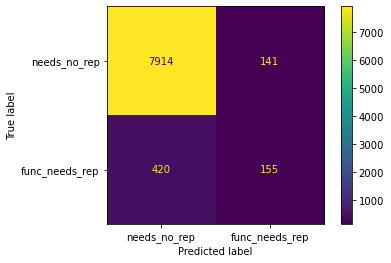

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8055
           1       0.52      0.27      0.36       575

    accuracy                           0.93      8630
   macro avg       0.74      0.63      0.66      8630
weighted avg       0.92      0.93      0.93      8630

func_needs_repair 4x more important: 0.40265101516449187


In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

predictions = knn_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=knn_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

print('func_needs_repair 4x more important: ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

#### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_cf = DecisionTreeClassifier(random_state=42)
dt_cf.fit(X_train_r, y_train_r)
y_pred = dt_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=dt_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [dt_cf, auc_train, auc_cv, acc_cv]

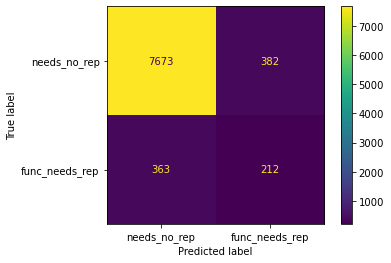

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8055
           1       0.36      0.37      0.36       575

    accuracy                           0.91      8630
   macro avg       0.66      0.66      0.66      8630
weighted avg       0.91      0.91      0.91      8630

func_needs_repair 4x more important: 0.47769116832082215


In [76]:
predictions = dt_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=dt_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

print('func_needs_repair 4x more important: ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

#### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_r, y_train_r)
y_pred = rf_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=rf_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [str(rf_cf), auc_train, auc_cv, acc_cv]

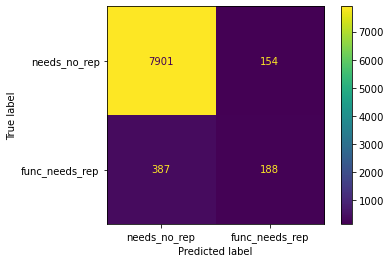

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8055
           1       0.55      0.33      0.41       575

    accuracy                           0.94      8630
   macro avg       0.75      0.65      0.69      8630
weighted avg       0.93      0.94      0.93      8630

func_needs_repair 4x more important: 0.4490275580633785


In [77]:
predictions = rf_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=rf_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

print('func_needs_repair 4x more important: ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

#### XGBoost

In [23]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier(use_label_encoder=False)
xgb_cf.fit(X_train_r, y_train_r)
y_pred = xgb_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=xgb_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv, acc_cv]

[19:02:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

#### Model Score Comparison

In [49]:
df_results.to_csv("pm2_sel_results.csv")
df_results

,Model,AUC Train,AUC CV,ACC CV
0,"LogisticRegression(max_iter=1000, random_state...",0.937079,0.933994,0.942522
1,KNeighborsClassifier(),0.971061,0.824438,0.936251
2,DecisionTreeClassifier(random_state=42),1.000000,0.690811,0.918971
3,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.915805,0.936680
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.981845,0.953004,0.941664
5,"SVC(probability=True, random_state=42)",0.944165,0.925288,0.942236


### Hyperparameter Tuning

Gewählte Modelle:
- LogisticRegression
- SupportVectorMachine
- XGBoost
--> Bester CV-Score

In [25]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV", "ACC CV"])

#### Logistic Regression

In [26]:
from sklearn.model_selection import RandomizedSearchCV

model_params = {
    'penalty' : ['l1', 'l2'],
    'C': np.linspace(1, 1000, 5, dtype=int),
    'max_iter' : np.linspace(1000, 3000, 3, dtype=int)
}
lr_cf = LogisticRegression(random_state=42)
rs = RandomizedSearchCV(lr_cf, param_distributions=model_params, scoring="roc_auc", cv=5, verbose = 2)
rs.fit(X_train_r, y_train_r)
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................C=1, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END .....................C=1, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END .....................C=1, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END .....................C=1, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END .....................C=1, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ...................C=250, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ...................C=250, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ...................C=250, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ...................C=250, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ...................C=250, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ...................C=500, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END ...................C=500, max_iter=3000

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logisti

{'penalty': 'l2', 'max_iter': 1000, 'C': 750}

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'penalty' : ['l1', 'l2'],
    'C': [250, 500, 1000],
    'max_iter' : [1000, 2000]
}]

lr_cf = LogisticRegression(random_state=42)
gs = GridSearchCV(lr_cf, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logisti

{'C': 250, 'max_iter': 1000, 'penalty': 'l2'}

In [30]:
lr_cf = gs.best_estimator_

lr_cf.fit(X_train_r, y_train_r)
y_pred = lr_cf.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=lr_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [lr_cf, auc_train, auc_cv, acc_cv]

#### SVM

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.0001]
}]

svm_cf = SVC(probability=True, random_state=42, kernel="rbf")
gs = GridSearchCV(svm_cf, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=2, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...................................C=1, gamma=0.001; total time= 8.6min
[CV] END ...................................C=1, gamma=0.001; total time= 8.6min
[CV] END ...................................C=1, gamma=0.001; total time= 8.7min
[CV] END ...................................C=1, gamma=0.001; total time= 8.7min
[CV] END ..................................C=1, gamma=0.0001; total time= 8.6min
[CV] END ..................................C=1, gamma=0.0001; total time= 8.7min
[CV] END ...................................C=1, gamma=0.001; total time= 8.8min
[CV] END ..................................C=1, gamma=0.0001; total time= 8.8min
[CV] END ..................................C=1, gamma=0.0001; total time= 9.1min
[CV] END ..................................C=10, gamma=0.001; total time= 9.1min
[CV] END ..................................C=1, gamma=0.0001; total time= 9.1min
[CV] END ..................................C=10, 

{'C': 1, 'gamma': 0.001}

In [53]:
svm_cf = gs.best_estimator_

svm_cf.fit(X_train_r, y_train_r)
y_pred = svm_cf.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=svm_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring, n_jobs=-1)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [svm_cf, auc_train, auc_cv, acc_cv]

#### XGBoost

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    "n_estimators":[100, 200, 300],
    "max_depth": [5, 10, 15],
    "learning_rate": [0.1, 0.5, 1]
}]

xgb_cf = XGBClassifier(use_label_encoder=False)
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[19:27:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [36]:
xgb_cf = gs.best_estimator_

xgb_cf.fit(X_train_r, y_train_r)
y_pred = xgb_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=xgb_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [xgb_cf, auc_train, auc_cv, acc_cv]

[21:12:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

#### Model Score Comparison

In [54]:
df_tuned.to_csv("pm2_tuned.csv")
df_tuned

,Model,AUC Train,AUC CV,ACC CV
0,"LogisticRegression(C=250, max_iter=1000, rando...",0.936965,0.933366,0.942583
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.970142,0.956230,0.943523
2,"SVC(C=1, gamma=0.001, probability=True, random...",0.936918,0.934234,0.931451


## Evaluation

- Test Set
- ROC Visualization

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

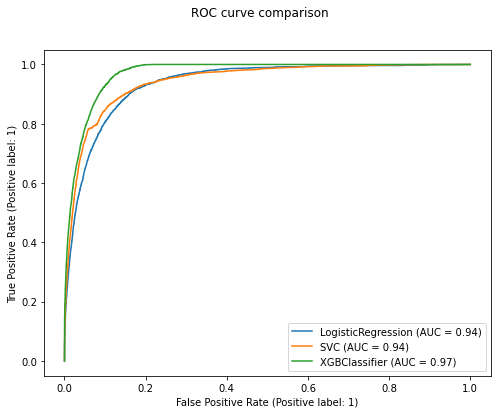

In [45]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

lr_disp = RocCurveDisplay.from_estimator(lr_cf, X_train_r, y_train_r)
svm_disp = RocCurveDisplay.from_estimator(svm_cf, X_train_r, y_train_r, ax=lr_disp.ax_)
xgb_disp = RocCurveDisplay.from_estimator(xgb_cf, X_train_r, y_train_r, ax=lr_disp.ax_)
lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()

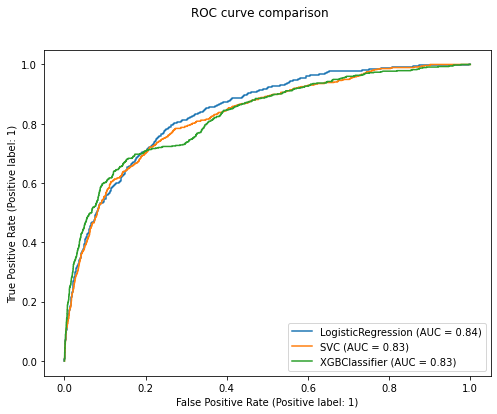

In [55]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

lr_disp = RocCurveDisplay.from_estimator(lr_cf, X_test, y_test_r)
svm_disp = RocCurveDisplay.from_estimator(svm_cf, X_test, y_test_r, ax=lr_disp.ax_)
xgb_disp = RocCurveDisplay.from_estimator(xgb_cf, X_test, y_test_r, ax=lr_disp.ax_)
lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()

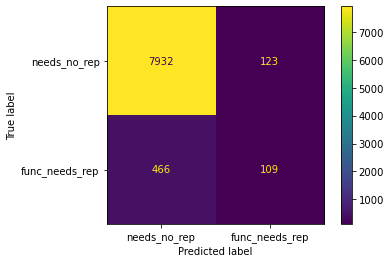

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8055
           1       0.47      0.19      0.27       575

    accuracy                           0.93      8630
   macro avg       0.71      0.59      0.62      8630
weighted avg       0.91      0.93      0.92      8630

func_needs_repair 4x more important: 0.3380021159756159


In [78]:
predictions = lr_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=lr_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

print('func_needs_repair 4x more important: ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

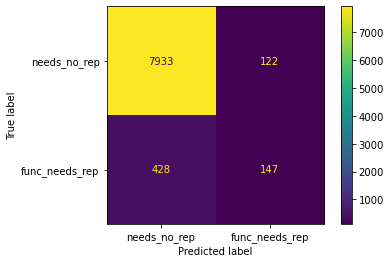

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8055
           1       0.55      0.26      0.35       575

    accuracy                           0.94      8630
   macro avg       0.75      0.62      0.66      8630
weighted avg       0.92      0.94      0.93      8630

func_needs_repair 4x more important: 0.39177550506322734


In [79]:
predictions = xgb_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=xgb_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

print('func_needs_repair 4x more important: ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

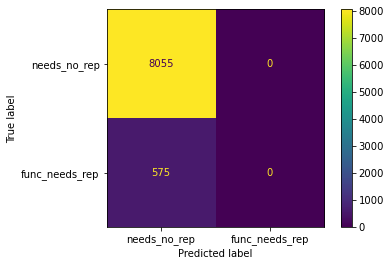

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      8055
           1       0.00      0.00      0.00       575

    accuracy                           0.93      8630
   macro avg       0.47      0.50      0.48      8630
weighted avg       0.87      0.93      0.90      8630

func_needs_repair 4x more important: 0.18667439165701044


In [81]:
predictions = svm_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=svm_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions, zero_division=0))

print('func_needs_repair 4x more important: ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))